In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
import spm1d.stats.c
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font
import spm1d
from stressgait_analysis.dataset import StressGaitDataset

# Inset axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib widget
%load_ext autoreload
%autoreload 2

from matplotlib.patches import Rectangle, ConnectionPatch


import warnings
warnings.simplefilter(action='ignore')
import numpy as np

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

controls_color = sns.color_palette(cmaps.wiso)[1]
omc_color = sns.color_palette(cmaps.med_dark)[1]

stressgait = {
    "omc": omc_color,
    "control": controls_color
}

In [3]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

export_path = Path("../../exports")
plot_path = export_path.joinpath("plots")
bp.utils.file_handling.mkdirs([export_path, plot_path])

export_path

PosixPath('../../exports')

In [4]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)


# Gait ROMs

In [5]:
kinematics = dataset.kinematics.droplevel(level="bout")

In [6]:
bad_cycles = kinematics[kinematics['elbow_angle']<80].index.droplevel('percentage_of_stride').drop_duplicates()
# Step 2: Filter out those cycles
kinematics_clean_arms = kinematics[~kinematics.index.droplevel('percentage_of_stride').isin(bad_cycles)]

In [7]:
def get_rom(trial):
    max = trial.groupby(["cycle_idx"]).max()
    min = trial.groupby(["cycle_idx"]).min()


    return np.mean(max - min, axis=0)


rom = kinematics.groupby(["participant", "condition", "speed"]).apply(get_rom)
rom_per_person = rom.groupby(["participant", "condition"]).mean().loc[:,["elbow_angle", "shoulder_angle", "arm_swing"]]

rom_arms = kinematics_clean_arms.groupby(["participant", "condition", "speed"]).apply(get_rom)
rom_per_person_arms = rom_arms.groupby(["participant", "condition"]).mean()

rom_per_person.loc[:,["elbow_angle", "shoulder_angle", "arm_swing"]] = rom_per_person_arms.loc[:,["elbow_angle", "shoulder_angle", "arm_swing"]]


rom_per_group = rom_per_person.groupby(["condition"]).mean()
rom_per_group

,elbow_angle,shoulder_angle,arm_swing
condition,,,
control,20.429005,24.899758,117.807000
omc,18.998119,25.951350,119.793249


<Axes: xlabel='angle', ylabel='value'>

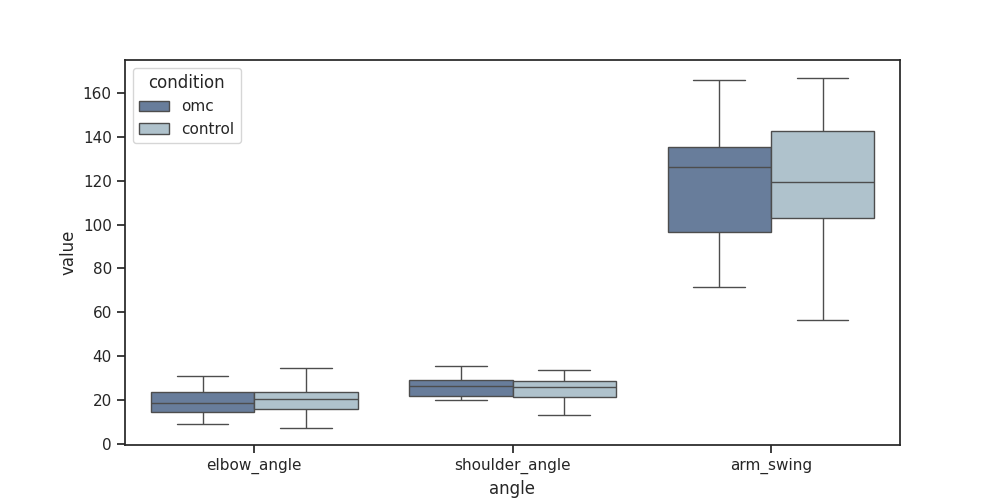

In [8]:
df_long = rom_per_person.reset_index().melt(
    id_vars=["participant", "condition"],  # Keep these columns
    var_name="angle",  # Name for the melted variable column
    value_name="value"  # Name for the melted value column
)
plt.figure()
sns.boxplot(x="angle", y="value", hue="condition", data=df_long, showfliers=False)

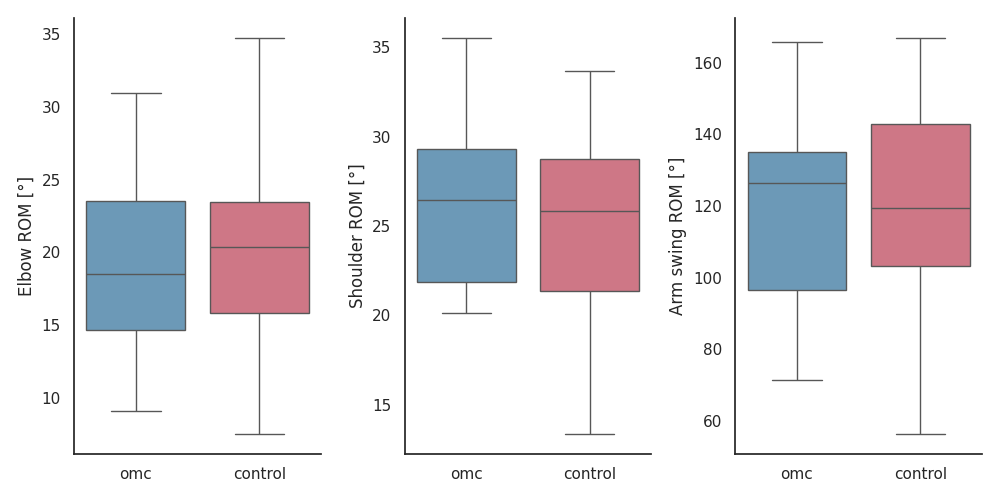

In [18]:
sns.set_style("white")
fig, axs=plt.subplots(figsize=(10,5),ncols=3)

for c, ax in zip(rom_per_person.columns, axs):
    sns.boxplot(data = rom_per_person[c].reset_index(), x="condition", y=c, hue = "condition", ax=ax, showfliers=True, palette=stressgait)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
   # ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

axs[0].set_ylabel("Elbow ROM [°]")
axs[1].set_ylabel("Shoulder ROM [°]")
axs[2].set_ylabel("Arm swing ROM [°]")
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")
fig.tight_layout()


plt.savefig("../../exports/ROM.pdf")

In [10]:
normality_results = df_long.groupby(['condition', "angle"], group_keys=False)["value"].apply(lambda g: pg.normality(g))
normality_results

W      pval  normal
control arm_swing       0.959833  0.540516    True
        elbow_angle     0.970208  0.759253    True
        shoulder_angle  0.930623  0.158741    True
omc     arm_swing       0.959158  0.527159    True
        elbow_angle     0.962595  0.596902    True
        shoulder_angle  0.936737  0.207900    True

In [11]:
test_results = df_long.groupby(["angle"], group_keys=False).apply(lambda g: pg.pairwise_tests(g, parametric=True, dv = "value", between="condition"))
test_results["p_corr"] = test_results["p-unc"]*len(df_long.angle.unique())
test_results["p_corr"].clip(upper=1, inplace=True)
test_results

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges,p_corr
0,condition,control,omc,False,True,-0.216656,38.0,two-sided,0.829635,0.315,-0.067151,1.0
0,condition,control,omc,False,True,0.752192,38.0,two-sided,0.456570,0.387,0.233138,1.0
0,condition,control,omc,False,True,-0.633758,38.0,two-sided,0.530035,0.362,-0.196430,1.0
